## Binary Classification with a Bank Churn Dataset
Objective of this model is to predict whether a customer continues with their account or closes it (e.g., churns).

In [ ]:
# setup
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json

Install dataset from Kaggle

In [ ]:
# download contest data
! kaggle competitions download -c playground-series-s4e1
! unzip playground-series-s4e1.zip

 73% 5.00M/6.81M [00:00<00:00, 44.7MB/s]
100% 6.81M/6.81M [00:00<00:00, 55.9MB/s]
Archive:  playground-series-s4e1.zip
  inflating: sample_submission.csv   
  inflating: test.csv                
  inflating: train.csv               


First, let's import training data. Before we continue, we perform some data pre-processing. In our data, we have columns of non-numerical data. We drop irrelevant ones and one-hot encode ones that do. Then, we scale numerical features as they originally consist of different ranges. We then finally allocate 20% of training data for validation testing.

In [82]:
import pandas as pd
import numpy as np

data_path = './train.csv'
data = pd.read_csv(data_path)

# Drop irrelevant columns (id, CustomerId, Surname)
data = data.drop(columns=["id", "CustomerId", "Surname"])

# one-hot encode categorical variables
data = pd.get_dummies(data, columns=["Geography", "Gender"])

# Seperate features and labels
labels = data["Exited"]
data = data.drop(columns=["Exited"])

Now, define model. We first make an attempt with a seque

Processing fold #1
Epoch 1/10
1075/1075 [==============================] - 5s 3ms/step - loss: 0.3486 - accuracy: 0.8541 - val_loss: 0.3257 - val_accuracy: 0.8652
Epoch 2/10
1075/1075 [==============================] - 4s 4ms/step - loss: 0.3354 - accuracy: 0.8599 - val_loss: 0.3307 - val_accuracy: 0.8629
Epoch 3/10
1075/1075 [==============================] - 3s 3ms/step - loss: 0.3334 - accuracy: 0.8610 - val_loss: 0.3233 - val_accuracy: 0.8653
Epoch 4/10
1075/1075 [==============================] - 3s 3ms/step - loss: 0.3331 - accuracy: 0.8613 - val_loss: 0.3233 - val_accuracy: 0.8638
Epoch 5/10
1075/1075 [==============================] - 4s 4ms/step - loss: 0.3328 - accuracy: 0.8617 - val_loss: 0.3338 - val_accuracy: 0.8651
Epoch 6/10
1075/1075 [==============================] - 3s 3ms/step - loss: 0.3327 - accuracy: 0.8613 - val_loss: 0.3275 - val_accuracy: 0.8604
Epoch 7/10
1075/1075 [==============================] - 3s 3ms/step - loss: 0.3318 - accuracy: 0.8618 - val_loss: 0.3

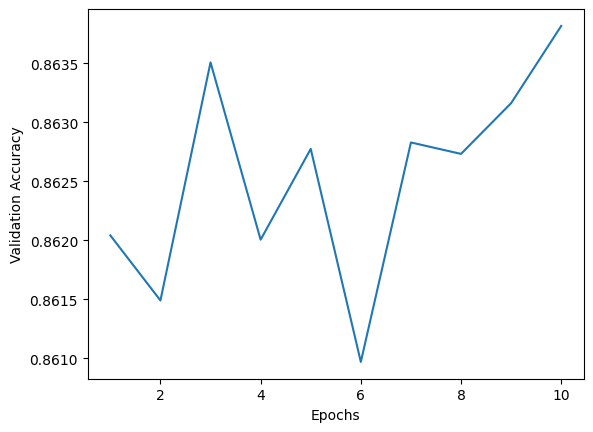

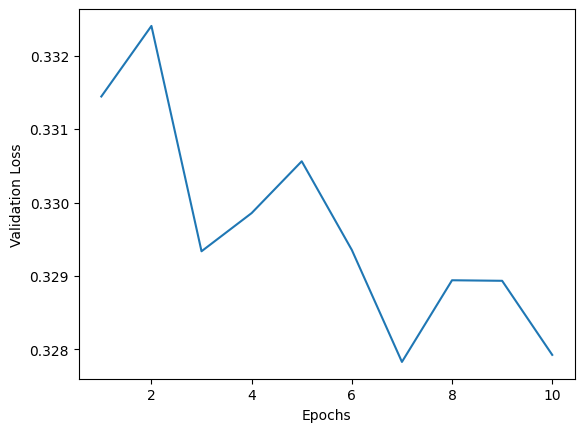

In [83]:
from tensorflow import keras
from keras import layers
import matplotlib.pyplot as plt
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.metrics import Accuracy
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler, MinMaxScaler

def build_model():
  model = keras.Sequential([
    layers.Dense(32, activation="relu"),
    layers.Dropout(0.2),
    layers.Dense(16, activation="relu"),
    layers.Dense(1, activation="sigmoid")
  ])

  model.compile(optimizer=RMSprop(learning_rate=0.01),
                loss=BinaryCrossentropy(),
                metrics=["accuracy"])

  return model

cv = KFold(n_splits=6, shuffle=True, random_state=42)
data = data.to_numpy()
labels = labels.to_numpy()

fold_num = 1
all_accuracy_histories = []
all_loss_histories = []

for train_i, val_i in cv.split(data, labels):
  print(f"Processing fold #{fold_num}")
  scaler = StandardScaler()
  train_data = data[train_i]
  val_data = data[val_i]
  scaler.fit(train_data)
  train_data = scaler.transform(train_data)
  val_data = scaler.transform(val_data)

  model = build_model()

  history = model.fit(train_data,
                      labels[train_i],
                      epochs=10,
                      batch_size = 128,
                      validation_data=(val_data, labels[val_i]))

  accuracy_history = history.history["val_accuracy"]
  loss_history = history.history["val_loss"]
  all_accuracy_histories.append(accuracy_history)
  all_loss_histories.append(loss_history)
  fold_num += 1

average_accuracy_history = [
    np.mean([x[i] for x in all_accuracy_histories]) for i in range(10)]

plt.plot(range(1, len(average_accuracy_history) + 1), average_accuracy_history)
plt.xlabel("Epochs")
plt.ylabel("Validation Accuracy")
plt.show()

average_loss_history = [
    np.mean([x[i] for x in all_loss_histories]) for i in range(10)]

plt.plot(range(1, len(average_loss_history) + 1), average_loss_history)
plt.xlabel("Epochs")
plt.ylabel("Validation Loss")
plt.show()





After we have evaluated performance metrics of the model on validation data and tuned model weights, we make predictions on test data set. Below is k-fold cross-validation attempt.

In [84]:
print(average_loss_history)
print(average_accuracy_history)

[0.3314441243807475, 0.33240488171577454, 0.32933707535266876, 0.32985686262448627, 0.33056212464968365, 0.3293552100658417, 0.32783076663812, 0.3289424578348796, 0.3289351165294647, 0.3279266655445099]
[0.8620405495166779, 0.8614891469478607, 0.8635069131851196, 0.8620042105515798, 0.8627736965815226, 0.8609680632750193, 0.8628282646338145, 0.8627313276131948, 0.8631615142027537, 0.8638159533341726]
